## Imports

In this Notebook, we'll check if the data is balanced or not, apply preprocessing funtions and finally apply the model.

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from preprocessing import encoding
from model_functions import split_data
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

### Is it balanced?

/home/macrodrigues/.pyenv/versions/3.9.5/envs/marco_venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


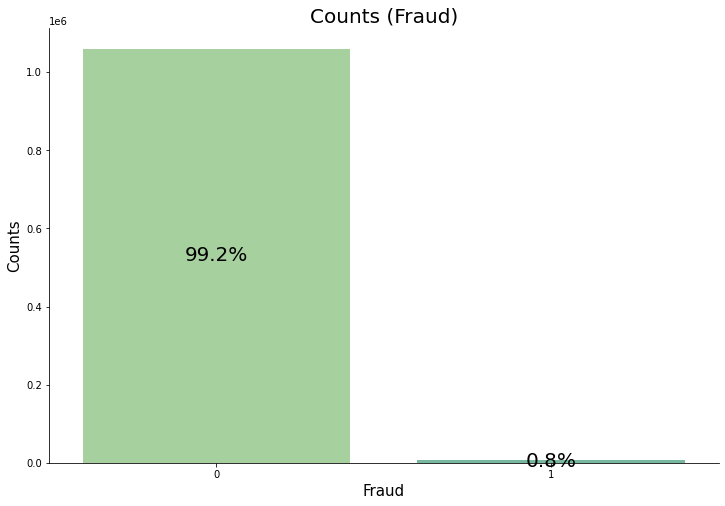

In [2]:
# IMPORT FROM CSV
df = pd.read_csv('data/data.csv')
df.drop([df.columns[0]], axis = 1, inplace=True)

# PLOT COUNTPLOT FOR TARGET
fig = plt.figure(figsize=(12, 8))
colors = [(160/255, 217/255, 149/255), (108/255, 196/255, 161/255)]
ax = sns.countplot(df['FRAUD'], palette=colors)
ax.set(title='Counts (Fraud)')
ax.title.set_size(20)  # Set title font size

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-label and y-label font size
ax.set_xlabel('Fraud', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)

# Add percentages to the plot
total = len(df['FRAUD'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=20)

plt.show()

The data is clearly not balanced.

This problem could be resolved by transforming the dataset into a new one with an equal number of elements of different classes. There are 3 possible solutions:

- Undersampling the majority class.
- Oversampling the minority class by creating a synthetic sample.
- Over and under-sampling.

### Undersampling

/home/macrodrigues/.pyenv/versions/3.9.5/envs/marco_venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


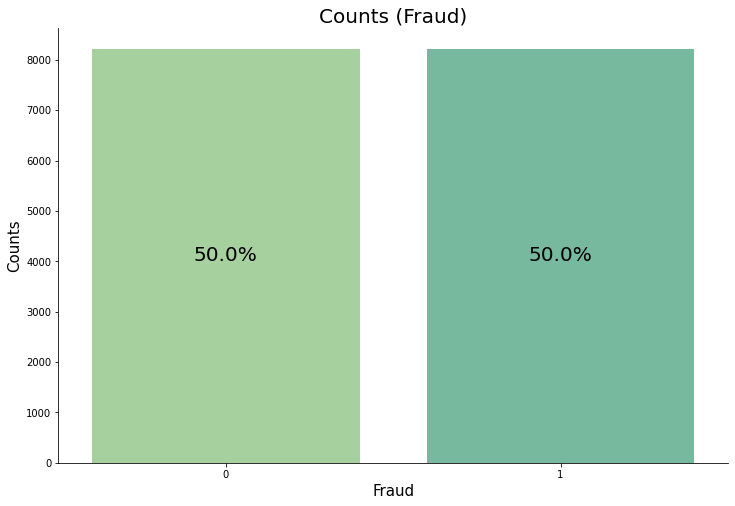

In [3]:
X = df.drop(['FRAUD'], axis=1)
y = df['FRAUD']

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_resample(X, y)

fig = plt.figure(figsize=(12, 8))
colors = [(160/255, 217/255, 149/255), (108/255, 196/255, 161/255)]
ax = sns.countplot(
    y_rus, 
    palette=colors)
ax.set(title='Counts (Fraud)')
ax.title.set_size(20)  # Set title font size

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-label and y-label font size
ax.set_xlabel('Fraud', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)

# Add percentages to the plot
total = len(y_rus)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=20)

plt.show()

Now that the target is balanced, let's see how much we lost:

In [4]:
X_rus.shape

(16444, 10)

### Preprocessing

Let's now create a new dataframe, with the new data.

Also, let's call the enconding function which applies One Hot Enconding and Target Enconding on the features.

In [6]:
df= pd.concat([X_rus, y_rus], axis=1)
df = encoding(df)
X = df[['AMOUNT_GBP',
    'countries_encoded',
    'user_year',
    'currencies_encoded', 
    'AGE_20-35', 
    'AGE_36-50', 
    'AGE_51-65',
    'AGE_66-80', 
    'STATE_COMPLETED', 
    'STATE_DECLINED', 
    'STATE_FAILED',
    'STATE_REVERTED', 
    'TYPE_ATM', 
    'TYPE_CARD_PAYMENT', 
    'TYPE_EXCHANGE',
    'TYPE_FEE', 
    'TYPE_TOPUP', 
    'TYPE_TRANSFER',
    'transaction_day_week_Friday', 
    'transaction_day_week_Monday',
    'transaction_day_week_Thursday', 
    'transaction_day_week_Tuesday',
    'transaction_day_week_Wednesday', 
    'transaction_day_week_Weekend']]
y = df['FRAUD']

### Split the data

In [7]:
X_train, X_test, y_train, y_test= split_data(X, y, split=0.3)

### Pearson Correlation

One of the fatest ways of doing feature selection is by using the pearson correlation with a heatmap.

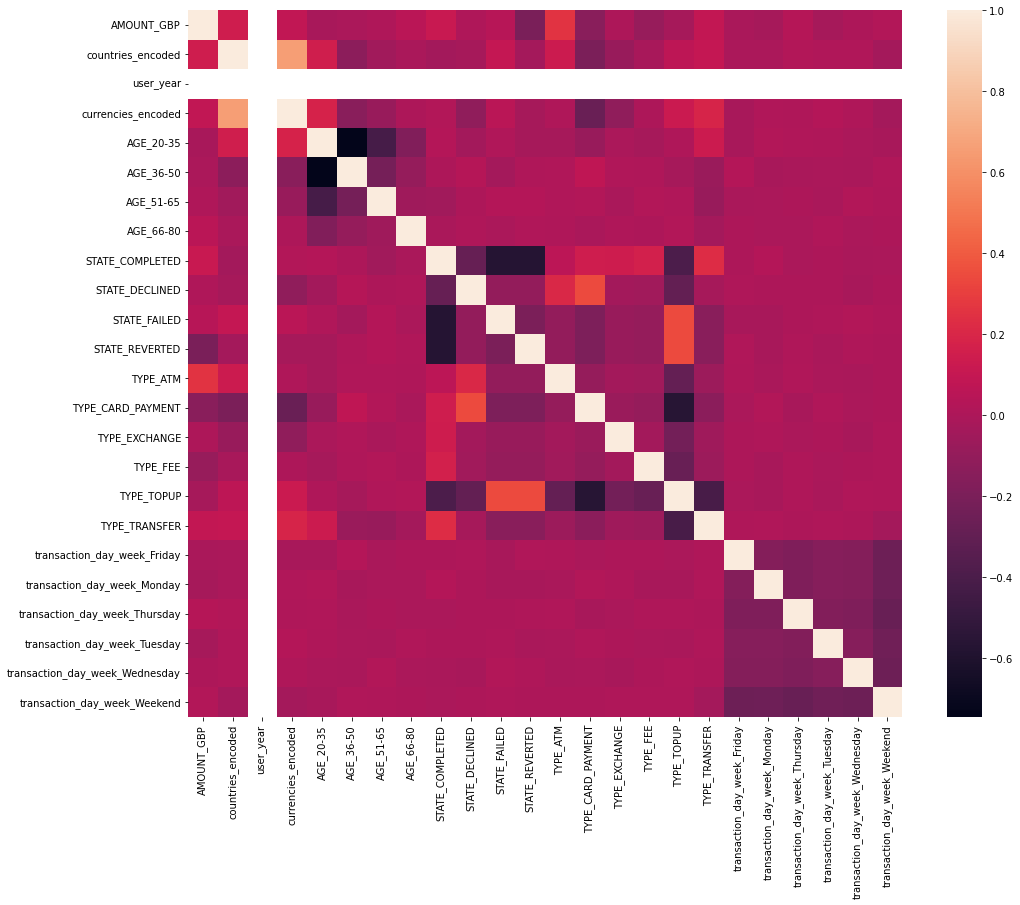

In [8]:
fig = plt.figure(figsize=(16, 13))
sns.heatmap(X_train.corr())
plt.show()

Cases of high correlation:

- countries_encoded too much correlated with countries_encoded (leave countries_encoded only)
- state_reverted and state_failed, can also be removed since they are very negatevly correlated with state_completed
- type_topup is negatively correlated with state_completed, Type_card payment and type transfer, so its also a good feature to remove


Let's generate the datafrane again, now with the new columns.

In [9]:
X = df[[
    'AMOUNT_GBP',
    'countries_encoded',
    'user_year', 
    'AGE_20-35', 
    'AGE_36-50', 
    'AGE_51-65',
    'AGE_66-80', 
    'STATE_COMPLETED', 
    'STATE_DECLINED', 
    'TYPE_ATM', 
    'TYPE_CARD_PAYMENT', 
    'TYPE_EXCHANGE',
    'TYPE_FEE', 
    'TYPE_TRANSFER',
    'transaction_day_week_Friday', 
    'transaction_day_week_Monday',
    'transaction_day_week_Thursday', 
    'transaction_day_week_Tuesday',
    'transaction_day_week_Wednesday', 
    'transaction_day_week_Weekend']]


X_train, X_test, y_train, y_test= split_data(X, y, split=0.3)

### Apply Model

Start by making a pipeline only for scaling.

In [12]:
num_features = [
    'AMOUNT_GBP',
    'countries_encoded',
    'user_year']

num_transformer = Pipeline([
    ('inputer', KNNImputer()),
    ('scaler', MinMaxScaler())])

# Build preprocessor
preprocessor = ColumnTransformer([
    ('num_tr', num_transformer, num_features)])

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

pipe_random_forest = make_pipeline(preprocessor, RandomForestClassifier())
pipe_random_forest.fit(X_train, y_train)

cv_results = cross_validate(pipe_random_forest, X_train, y_train, cv = 20)

In [14]:
cv_results['test_score'].mean()

0.8307558876811594

GridSearch for fine-tuning

In [15]:
# define evaluation
cv = RepeatedKFold(n_splits=5, n_repeats=2)

# define search space
space = dict()
space['max_features'] = ['sqrt', 'log2']
space['min_samples_split'] = [1, 2, 3, 4]
space['n_estimators'] = [100, 120, 80]
space['criterion'] = ['gini', 'entropy']

# define search
search = GridSearchCV(RandomForestClassifier(), space, n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/home/macrodrigues/.pyenv/versions/3.9.5/envs/marco_venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/macrodrigues/.pyenv/versions/3.9.5/envs/marco_venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/macrodrigues/.pyenv/versions/3.9.5/envs/marco_venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/macrodrigues/.pyenv/versions/3.9.5/envs/marco_v

Best Score: 0.852997393570808
Best Hyperparameters: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 120}


Make the pipeline with the best parameters

In [16]:
from sklearn.ensemble import RandomForestClassifier

best_pipe = make_pipeline(
    preprocessor, 
    RandomForestClassifier(
        max_features= result.best_params_['max_features'],
        min_samples_split= result.best_params_['min_samples_split'],
        n_estimators= result.best_params_['n_estimators'],
        criterion= result.best_params_['criterion']))

best_pipe.fit(X_train, y_train)

cv_results = cross_validate(best_pipe, X_train, y_train, cv = 20)
cv_results['test_score'].mean()

0.8316245471014494

#### Model Evaluation

In [17]:

y_pred_test = best_pipe.predict(X_test)
y_pred_test

array([1, 0, 0, ..., 0, 0, 1])

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
accuracy_score(y_test, y_pred_test)

0.8354276449128496

In [20]:
confusion_matrix(y_test, y_pred_test)

array([[1876,  609],
       [ 203, 2246]])

In [21]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      2485
           1       0.79      0.92      0.85      2449

    accuracy                           0.84      4934
   macro avg       0.84      0.84      0.83      4934
weighted avg       0.84      0.84      0.83      4934



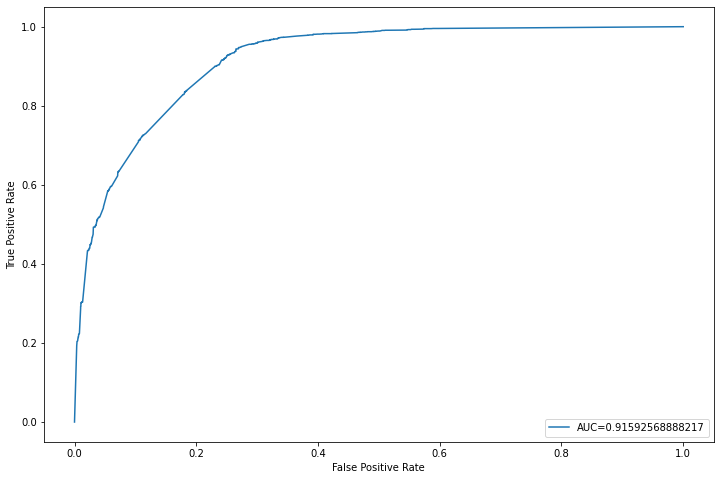

In [22]:
from sklearn import metrics

#define metrics
y_pred_proba = best_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test,  y_pred_proba)

#create ROC curve
fig = plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
